In [1]:
#package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

In [3]:
training_data.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [4]:
# Separate success/fail sets
pizza = training_data[training_data['requester_received_pizza'] == True]
no_pizza = training_data[training_data['requester_received_pizza'] == False]
no_pizza_short = no_pizza[:len(pizza)]

# Create new dataframe with equal outcomes
new_train = pd.concat([pizza, no_pizza_short], axis = 0)
new_train = new_train.sample(frac=1) # shuffle
new_train.reset_index()
new_train['requester_received_pizza'] = new_train['requester_received_pizza'].astype(int) # boolean to 0/1

# Split data and set the appropriate columns
test_features = test_data.columns
Y = new_train['requester_received_pizza']
X = new_train[training_data.columns[training_data.columns.isin(test_features)]]

# Split for train and validation
val_split = int(len(new_train) * 0.9)
train_data, train_labels = X[:val_split], Y[:val_split]
val_data, val_labels = X[val_split:], Y[val_split:]


# Get only request text
train_requests = train_data['request_text_edit_aware'].str.lower().tolist()
val_requests = val_data['request_text_edit_aware'].str.lower().tolist()

## One-hot encoding for the data

In [5]:
money = ['money',
        'rent',
        'broke',
        'paid',
        'spent',
        'rent',
        'bills',
        'paycheck',
        'accident',
        'payment',
         'struggle',
         'landlord',
         'debt',
         'unexpected',
         'dollars',
         'budget',
         'stamps',
         'medical',
         'hospital',
         'check',
         'month',
         'week',
         'accident',
         'car'
        ]

hunger = ['food',
        'hungry',
        'starving',
        'starve',
        'empty',
        'ramen',
        'nothing',
         'eaten',
         'belly',
         'stomach',
         'fridge',
         'cupboard',
         'leftovers',
         'groceries',
         'pantry',
         'meal']

unemployed = ['job',
            'work',
            'unemployed',
             'laid off',
             'fired',
             'grad']

gratitude = ['thank',
             'kind',
             'pay it forward',
             'give back',
            'sincere',
            'help',
            'promise',
            'appreciate']

In [6]:
def encode_one_hot(text, data):
    one_hot = []
    requests = data['request_text_edit_aware'].str.lower().tolist()
    
    for i in range(len(data)):
        check = []

        for word in text:
            if word in requests[i]:
                check.append(True)
                break
            else:
                check.append(False)
            
        if any(check):
            one_hot.append(1)
        else:
            one_hot.append(0)

    
    return one_hot

In [7]:
money_req = encode_one_hot(money, train_data)
train_data['money'] = money_req

In [8]:
hunger_req = encode_one_hot(hunger, train_data)
train_data['hungry'] = hunger_req

In [9]:
unemployed_req = encode_one_hot(unemployed, train_data)
train_data['job'] = unemployed_req

In [10]:
gratitude_req = encode_one_hot(gratitude, train_data)
train_data['thanks'] = gratitude_req

In [11]:
money_req = encode_one_hot(money, val_data)
val_data['money'] = money_req

In [12]:
hunger_req = encode_one_hot(hunger, val_data)
val_data['hungry'] = hunger_req

In [13]:
unemployed_req = encode_one_hot(unemployed, val_data)
val_data['job'] = unemployed_req

In [14]:
gratitude_req = encode_one_hot(gratitude, val_data)
val_data['thanks'] = gratitude_req

In [15]:
# Use only specific features
tree_features = ['requester_account_age_in_days_at_request',
                'requester_number_of_comments_in_raop_at_request',
                'requester_upvotes_plus_downvotes_at_request',
                'money',
                'hungry',
                'thanks',
                'job']

tr_train = train_data[train_data.columns[train_data.columns.isin(tree_features)]]
tr_val = val_data[val_data.columns[val_data.columns.isin(tree_features)]]

Using a decision stump -- a tree with depth 3:
Feature importances: [0.04449221 0.29080572 0.36360862 0.2378222  0.06327125 0.
 0.        ]
Validation Accuracy: 0.5678391959798995


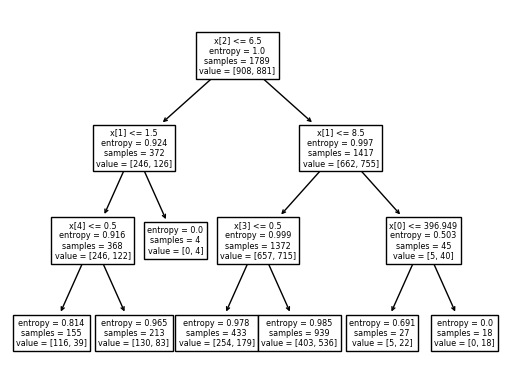

In [16]:
# Set classifier and fit for decision tree
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dt.fit(tr_train, train_labels)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 3:')
print ('Feature importances:', dt.feature_importances_)
print ('Validation Accuracy:', dt.score(tr_val, val_labels))

In [17]:
forest = RandomForestClassifier(n_estimators = 10)

forest.fit(tr_train, train_labels)

print ('Training Accuracy:', forest.score(tr_train, train_labels))
print ('Validation Accuracy:', forest.score(tr_val, val_labels))

Training Accuracy: 0.917272219116825
Validation Accuracy: 0.5175879396984925


In [18]:
rm_val_predictions = forest.predict(tr_val)

confusion_matrix(val_labels, rm_val_predictions)

array([[50, 36],
       [60, 53]])

## Test predictions

In [19]:
money_req = encode_one_hot(money, test_data)
test_data['money'] = money_req

In [20]:
hunger_req = encode_one_hot(hunger, test_data)
test_data['hungry'] = hunger_req

In [21]:
unemployed_req = encode_one_hot(unemployed, test_data)
test_data['job'] = unemployed_req

In [22]:
gratitude_req = encode_one_hot(gratitude, test_data)
test_data['thanks'] = gratitude_req

In [23]:
tr_test = test_data[test_data.columns[test_data.columns.isin(tree_features)]]

In [28]:
# tree predictions
test_predictions = dt.predict(tr_test)
rm_test_predictions = forest.predict(tr_test)

In [29]:
rm_test_predictions

array([0, 0, 0, ..., 0, 1, 0])

In [30]:
def get_submission_csv(predictions):
    test_ids = test_data['request_id']
    
    d = {'request_id': test_ids,
    'requester_received_pizza': predictions}
    
    df = pd.DataFrame(data=d)
    df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
    
    return df

In [31]:
df

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0
...,...,...
1626,t3_knttk,0
1627,t3_11wza2,1
1628,t3_iwbsf,0
1629,t3_nys7g,1


In [26]:
df = get_submission_csv(rm_test_predictions)

In [27]:
#df.to_csv('rf_model.csv', index=False)